In [126]:
import json
import os
import pickle as pkl
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")

import AIPT.Models.Beshnova2020.CNN
import AIPT.Models.Beshnova2020.pca_embedding
import AIPT.Utils.logging
import AIPT.Utils.plotting

print("current working directory:")
%pwd

current working directory:


'/home/ec2-user/SageMaker/antibody-in-pytorch/AIPT/Models/Beshnova2020'

In [127]:
import AIPT.Utils.Dev.dev_utils as dev_utils

aipt_path = '/home/ec2-user/SageMaker/antibody-in-pytorch/'
aipt_reload = dev_utils.get_aipt_reload_fn(aipt_path)

In [128]:
'''
set up paths
'''

aipt_dir = '/home/ec2-user/SageMaker/antibody-in-pytorch/AIPT' # replace with your own aipt path
# print("\t".join(os.listdir(aipt_dir)))
!ls {aipt_dir}

Benchmarks	__init__.py  Models	  Utils
entry_point.py	__main__.py  __pycache__


## Data Processing

In [129]:
# todo: pca

In [130]:
from AIPT.Benchmarks.OAS_dataset import OAS_data_loader as oas

In [131]:
seq_dir = os.path.join(aipt_dir, "Benchmarks/OAS_dataset/data/seq_db")
model_dir = 'AIPT/Models/Beshnova2020'
model_dir_abs = os.path.join(aipt_path, model_dir)
%cd {model_dir_abs}
index_fn = "OAS_index.txt"
index_path = os.path.join(aipt_path, model_dir, index_fn)
input_seq_type = "CDR3"
output_field = "BType"
cell_types = [
    "Naive-B-Cells",
    "Memory-B-Cells",
]  # todo: this is confusing - doesn't refer to "Species"

train_loader, train_eval_loader, test_eval_loader, seq_len = oas.OAS_data_loader(
    index_path,
    output_field,
    input_seq_type,
    cell_types,
    seq_dir=seq_dir,
    gapped=True,
    pad=False,
    batch_size=20,
    model_name="Beshnova2020",
)

/home/ec2-user/SageMaker/antibody-in-pytorch/AIPT/Models/Beshnova2020
Training data                                            file_name Longitudinal  Chain  \
0  Ellebedy_2016_Day-0_memory-B-cell_IGHA_memory-...        Day-0  Heavy   
1  Ellebedy_2016_Day-0_memory-B-cell_IGHA_memory-...        Day-0  Heavy   
2  Ellebedy_2016_Day-0_memory-B-cell_IGHG_memory-...        Day-0  Heavy   

                    Author Isotype    Age  Size_igblastn Disease  \
0  Ellebedy et al., (2016)    IGHA  18-49          84333    None   
1  Ellebedy et al., (2016)    IGHA  18-49          59091    None   
2  Ellebedy et al., (2016)    IGHG  18-49          52891    None   

                                      Link BSource           BType   Size  \
0  https://www.nature.com/articles/ni.3533    PBMC  Memory-B-Cells  61336   
1  https://www.nature.com/articles/ni.3533    PBMC  Memory-B-Cells  43137   
2  https://www.nature.com/articles/ni.3533    PBMC  Memory-B-Cells  41221   

  Species Vaccine  Subject  v

In [132]:
import pandas as pd
index_df = pd.read_csv(index_path, sep="\t")

file_names = index_df['file_name']

In [133]:
data_dfs = []

for index, row in index_df.iterrows():
    file_name = row['file_name']
    df = pd.read_csv(os.path.join(seq_dir, f'{file_name}.txt'), sep='\t')
    length_df = df.apply(lambda row: len(row['CDR3_aa']), axis=1)
    data_df = df[length_df == 12]
    data_df['BType'] = row['BType']
    data_df = data_df[['CDR3_aa', 'BType']]
    data_dfs.append(data_df)
    
data = pd.concat(data_dfs)
data

,CDR3_aa,BType
1,AREYARHNPGGD,Memory-B-Cells
2,TRPNGGDYAFDI,Memory-B-Cells
17,VKDWGGSYHFDR,Memory-B-Cells
26,ASSWYGGYYFDY,Memory-B-Cells
27,ARDKGASYYFDY,Memory-B-Cells
...,...,...
1527,ARGGTGTTNFGY,Naive-B-Cells
1530,ARLTGTHPYFDY,Naive-B-Cells
1533,ARVSVSTGWFDP,Naive-B-Cells
1535,ARLDRTVYGMDV,Naive-B-Cells


In [134]:
cell_type_to_ix = {cell_type: ix for ix, cell_type in enumerate(cell_types)}
print('cell_type_to_ix:', cell_type_to_ix)

data['label'] = data.apply(lambda row: cell_type_to_ix[row['BType']], axis=1)
data

cell_type_to_ix: {'Naive-B-Cells': 0, 'Memory-B-Cells': 1}


,CDR3_aa,BType,label
1,AREYARHNPGGD,Memory-B-Cells,1
2,TRPNGGDYAFDI,Memory-B-Cells,1
17,VKDWGGSYHFDR,Memory-B-Cells,1
26,ASSWYGGYYFDY,Memory-B-Cells,1
27,ARDKGASYYFDY,Memory-B-Cells,1
...,...,...,...
1527,ARGGTGTTNFGY,Naive-B-Cells,0
1530,ARLTGTHPYFDY,Naive-B-Cells,0
1533,ARVSVSTGWFDP,Naive-B-Cells,0
1535,ARLDRTVYGMDV,Naive-B-Cells,0


In [135]:
from AIPT.Benchmarks.OAS_dataset import OAS_data_loader
from sklearn.model_selection import train_test_split

# train_data = data[['CDR3_aa', 'label']]
# seq_encodings = OAS_data_loader.encode_index(data=train_data['CDR3_aa'])
# btypes = train_data['label'].values
# train_loader = torch.utils.data.DataLoader(list(zip(seq_encodings, btypes)), shuffle=True, batch_size=32)

def get_data_loader(data, batch_size=22):
    seq_encodings = OAS_data_loader.encode_index(data=data['CDR3_aa'])
    btypes = data['label'].values
    loader = torch.utils.data.DataLoader(list(zip(seq_encodings, btypes)), shuffle=True, batch_size=100, drop_last=True)
    return loader

train_data, test_data = train_test_split(data, train_size=0.8)
train_loader = get_data_loader(train_data)
test_loader = get_data_loader(test_data)

## Load Model

In [136]:
aipt_reload(AIPT.Models.Beshnova2020.CNN)
aipt_reload(AIPT.Models.Beshnova2020.pca_embedding)
aipt_reload(AIPT.Utils.logging)
aipt_reload(AIPT.Utils.plotting)
from AIPT.Models.Beshnova2020.CNN import CNN
import AIPT.Models.Beshnova2020.pca_embedding as pca_embedding
from AIPT.Utils.logging import today, current_time
from AIPT.Utils.plotting import plot_roc_curves


File: /home/ec2-user/SageMaker/.persisted_conda/aipt/lib/python3.6/site-packages/AIPT-0.0.1-py3.6.egg/AIPT/Models/Beshnova2020/CNN.py 
 Last modified: 2020-10-23 00:00:40 UTC

File: /home/ec2-user/SageMaker/.persisted_conda/aipt/lib/python3.6/site-packages/AIPT-0.0.1-py3.6.egg/AIPT/Models/Beshnova2020/pca_embedding.py 
 Last modified: 2020-10-23 00:00:41 UTC




In [137]:
import os

log_root_dir = '/home/ec2-user/SageMaker/logs/tensorboard'
run_name = 'test'
timezone = 'EST'

para_dict = {
    'seq_len': 12,
    'embedding_dim': 15, # paper uses dim 15 PCA features
    'epoch': 1000,
    'classes': cell_types,
    'learning_rate': 10**-4,
    'run_name': run_name,
    'log_dir': os.path.join(log_root_dir, today(tz=timezone), run_name, current_time(tz=timezone))
}

pca_para_dict = para_dict.copy()
pca_para_dict['model_name'] = 'pca'
pca_embedding_fn = pca_embedding.embedding_fn(20, pca_para_dict['embedding_dim'])
pca_model = CNN(pca_para_dict, pca_embedding_fn)

general_para_dict = para_dict.copy()
general_para_dict['model_name'] = 'general'
general_embedding_fn = nn.Embedding(20, general_para_dict['embedding_dim'])
general_model = CNN(general_para_dict, general_embedding_fn)

print('LOG DIR:', para_dict['log_dir'])

LOG DIR: /home/ec2-user/SageMaker/logs/tensorboard/2020-10-22/test/19.00.44


## Tensorboard

In [138]:
import subprocess as sp

start_tensorboard = False

if start_tensorboard:
    reload_interval = "15"  # seconds
    tensorboard_proc = sp.Popen(
        [
            "tensorboard",
            "--logdir",
            para_dict["log_dir"],
        ],
        universal_newlines=True,
        stdout=sp.PIPE,
        stderr=sp.PIPE,
    )

## Train

In [139]:
general_model.fit(train_loader, test_loader=test_loader)
pca_model.fit(train_loader, test_loader=test_loader)

fit called
width 2
Found saved model from Epoch 1000
fit called
width 2
Found saved model from Epoch 1000


[[ 247   65]
 [  54 1734]]
Accuracy = 0.943 ,MCC = 0.773
[[ 271   46]
 [  21 1762]]
Accuracy = 0.968 ,MCC = 0.872


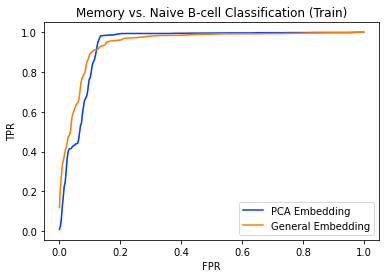

<AxesSubplot:title={'center':'Memory vs. Naive B-cell Classification (Train)'}, xlabel='FPR', ylabel='TPR'>

In [140]:
figure_dir = os.path.join(model_dir_abs, 'figures')
figure_path = os.path.join(figure_dir, 'memory_naive_roc_train.png')

general_output, general_labels, general_loss = general_model.predict(train_loader)
general_model.evaluate(general_output, general_labels)
pca_output, pca_labels, pca_loss = pca_model.predict(train_loader)
pca_model.evaluate(pca_output, pca_labels)
plot_roc_curves(
    [pca_output[:, 1], general_output[:, 1]],
    [pca_labels, general_labels],
    ["PCA Embedding", "General Embedding"],
    title="Memory vs. Naive B-cell Classification (Train)",
    save_path=figure_path
)

## Test

In [141]:
output, labels, loss = model.predict(test_loader)
print(loss)
model.evaluate(output, labels)

ModuleAttributeError: 'CNN' object has no attribute 'conv1'

## Tensorboard Output

In [ ]:
# for line in iter(tensorboard_proc.stdout):
#     print(line)
# print(tensorboard_proc.stdout)
# print(tensorboard_proc.stderr)
# todo: get this output piping to work